In [1]:
import numpy as np
import qiskit as qk
import math
from qiskit import Aer
import os
import random as my_random


from calibration_functions import *  
# Functions:
# get_readout_err(experimental_backend, number_of_shots)      find calibrating matrix B 
# calibrate_readout_err(exper_expect_val , B)       find calibrated exp_value vector

from transfer_matrix_tools import *
# Functions:
# calculate_gate_fidelity(n, Transfer_matrix_ideal,Transfer_matrix)     n=number f qubits
# calculate_transfer_matrix(input_expected_values,output_expected_values)
# plot_transfer_matrix(Transfer_matrix)

from theoretical_tools import *
# Functions:
# exp_value_braket(statevector,operator)

from backend_tools import *
# Functions:
# IBM_backend('ibm_backend')
# QI_backend('qi_backend' )
# simulator_backend()
# noisy_simulator_backend()

In [2]:
#BACKEND AND NUMBER OF SHOTS

experimental_backend = simulator_backend()
number_of_shots = 1000
experiment_name='SIMULATION'

In [3]:
states = [np.array([1,0]),np.array([0,1]),1/np.sqrt(2) * np.array([1,1]), \
          1/np.sqrt(2) * np.array([1,-1]), 1/np.sqrt(2) * np.array([1, complex(0,1)]), 1/np.sqrt(2) * np.array([1, complex(0,-1)])]
possible_directions = ['I', 'X','Y', 'Z']


experiment_directory=os.path.join('data_collected', experiment_name)

#if the folder does not exist, create it
if not os.path.exists(experiment_directory):
    os.makedirs(experiment_directory)


#PAULI GATES
pauli_g=np.zeros((4,2,2),dtype = np.complex_)
pauli_g[0] = np.array([[1,0],[0,1]]) 
pauli_g[1] = np.array([[0,1],[1,0]]) 
pauli_g[2] = np.array([[0,complex(0,-1)],[complex(0,1),0]]) 
pauli_g[3] = np.array([[1,0],[0,-1]])


sv_expected_values=np.zeros((6, 4))
precalibration_exp_values=np.zeros((6, 4))
output_expected_values = np.zeros((6, 4))
input_expected_values = np.zeros((6, 4))


m=0                      # goes from 0 to 6 (6 cardinal states)
for state1 in states:
    d1d2=0           #   
    n=0              #  
    d2=0             #direction 2  (the only direction) numbering
    for direction2 in possible_directions:
        
        
        input_state_vector=state1
        
        input_expected_values[m,d1d2]=  exp_value_braket(input_state_vector, pauli_g[d2] )    # <'Direction2' 'Direction1'> =  <bra| D2D1_matrix   |ket> 
    

        

        if direction2 == 'I' : # For the I case we don't need a circuit
            output_expected_values[m,0] = 1
            precalibration_exp_values[m,0] = 1
            sv_expected_values[m,0]=1
            d2+=1
            d1d2+=1
            continue  
        #print("Let's find the expectation value for the", direction1, direction2, 'measurements')
        expected_value=0
        for shot in range(number_of_shots):
            # Define circuit
            q = qk.QuantumRegister(1)
            c = qk.ClassicalRegister(1)
            circuit = qk.QuantumCircuit(q, c)
            
            # Do some initialization for the input states
            circuit.initialize(state1, 0)  # Initialize the 0th qubit using a complex vector
                

                    #INPUT PROCESS
                            
            # MODELLING OF THE PROCESS
        
            
            rand=my_random.randint(0,3)
            
            if (not rand==0 ):
                
                #  DEPOLARISING CHANNEL 
                #randstate=qk.quantum_info.random_state(2)#get some reandom state
                
                # AMPLITUDE DAMPING CHANNEL
                circuit.initialize(states[0], 0)      

            
            if direction2 == 'X' : 
                circuit.ry(-math.pi/2, q[0])
            elif direction2 == 'Y' : 
                circuit.rx(math.pi/2, q[0])


            circuit.measure(q, c)    # Measure both bits

            # Define the experiment


            experimental_job = qk.execute(circuit, backend=experimental_backend, shots=1)
            experimental_result = experimental_job.result()

            # Look at the results
            histogram = experimental_result.get_counts(circuit)
            
            # Add the results to the results matrix
            
            for state, counts in histogram.items() :           
                expected_value += (-1)**(int(state[0]))*int(counts)    #corresponds to ZI               


        expected_value = expected_value / number_of_shots


        ## Calculation of <U>  
        precalibration_exp_values[ m ,d2] = expected_value
        


        #save data
        np.save(os.path.join(experiment_directory, 'precalibration_exp_values')  ,precalibration_exp_values)
        np.save(os.path.join(experiment_directory, 'input_expected_values')      ,input_expected_values)

        print(' m = ',m,' n = ',n)
        n += 1
        d2+=1
        d1d2+=1

    m += 1

print('Experiment Completed!')

 m =  0  n =  0
 m =  0  n =  1
 m =  0  n =  2
 m =  1  n =  0
 m =  1  n =  1
 m =  1  n =  2
 m =  2  n =  0
 m =  2  n =  1
 m =  2  n =  2
 m =  3  n =  0
 m =  3  n =  1
 m =  3  n =  2
 m =  4  n =  0
 m =  4  n =  1
 m =  4  n =  2
 m =  5  n =  0
 m =  5  n =  1
 m =  5  n =  2
Experiment Completed!


In [4]:
precal_transfer_matrix= calculate_transfer_matrix( input_expected_values, precalibration_exp_values )

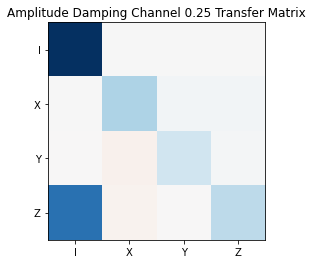

In [5]:
plot_transfer_matrix(precal_transfer_matrix,'Amplitude Damping Channel 0.25 Transfer Matrix')